In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [232]:
bb = pd.read_csv('dataset/bbox_light.csv')

In [233]:
def find_center(frame):
  return np.array([int((frame['x1'] + frame['x2'])/2), int((frame['y1'] + frame['y2'])/2)])

bb['center'] = bb.apply(find_center, axis=1)

In [262]:
def extract_point_from_patch(xyz, u, v, init_patch=1, max_patch=5, min_valid_frac=0.25):
    """
    Robustly extract a 3D point from an (H,W,3) xyz array at pixel (u,v).
    - init_patch: half-size of initial square patch (1 => 3x3)
    - max_patch: maximum half-size to expand to (5 => 11x11)
    - min_valid_frac: minimum fraction of valid points required to accept result
    
    Returns:
      (X, Y, Z) tuple of floats if successful, or None if no valid measurement.
    """
    H, W, C = xyz.shape
    assert C >= 3, "xyz must have at least 3 channels"
    u = int(round(u))
    v = int(round(v))

    for patch in range(init_patch, max_patch+1):
        u0 = max(0, u - patch)
        u1 = min(W-1, u + patch)
        v0 = max(0, v - patch)
        v1 = min(H-1, v + patch)
        window = xyz[v0:v1+1, u0:u1+1, :3]         # shape (h,w,3)
        pts = window.reshape(-1, 3)

        # valid mask: finite and non-zero-norm (tune threshold if needed)
        valid = np.isfinite(pts).all(axis=1) & (np.linalg.norm(pts, axis=1) > 1e-6)
        n_valid = np.count_nonzero(valid)
        total = pts.shape[0]

        if n_valid / total >= min_valid_frac and n_valid > 0:
            valid_pts = pts[valid]
            # Use median (robust). You could use mean if you prefer.
            X = np.median(valid_pts[:, 0])
            Y = np.median(valid_pts[:, 1])
            Z = np.median(valid_pts[:, 2])
            return float(X), float(Y), float(Z)
        # else: expand patch and retry
    # If we reach here, we failed to find enough valid points
    return None


def get_coords(frame: pd.Series):
  point_cloud = np.load(f'dataset/xyz/depth{frame.name:06d}.npz')['xyz']
  coords = point_cloud[frame['center'][1], frame['center'][0]][:-1]
  # return extract_point_from_patch(point_cloud, frame['center'][0], frame['center'][1])
  return coords


In [263]:
bb['coords'] = bb.apply(get_coords, axis=1)

In [265]:
bb_clean = bb.loc[~(bb.apply(lambda x: x['coords'][0], axis=1)).isna()] #dropping any frames where coordinates are N/A

In [266]:
trajectory = bb_clean[['frame', 'coords']].copy()

In [268]:
trajectory['xy-plane'] = trajectory.apply(lambda x: x['coords'][:2], axis=1) # removing the z coordinate since it doesn't matter for our plot

points = trajectory['xy-plane']
points_x = [x[0] if type(x) != int else 0 for x in points]
points_y = [y[1] if type(y) != int else 0 for y in points]

In [270]:

# Traffic-light coords in camera frame
dx = points_x
dy = points_y

# Angle of the first vector (camera → traffic light at t=0)
theta0 = np.arctan2(dy[0], dx[0])

# 2×2 rotation matrix for a clockwise rotation by theta0
c, s = np.cos(-theta0), np.sin(-theta0)
R = np.array([[c, -s],
              [s,  c]])

# Apply rotation to all points
rotated = R @ np.vstack([dx, dy])
x_aligned, y_aligned = rotated

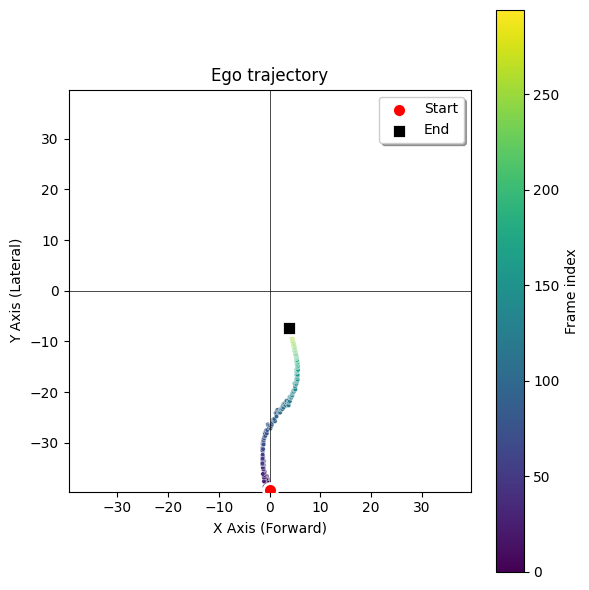

In [283]:
data = {"new_x": [-y for y in y_aligned], "new_y": [-x for x in x_aligned], "frame": np.arange(len(x_aligned))}

fig, ax = plt.subplots(figsize=(6, 6))

# Use a colormap (continuous) and tell Seaborn to treat hue as numeric
sns.scatterplot(
    x="new_x",
    y="new_y",
    hue="frame",
    palette=sns.color_palette("viridis", as_cmap=True),  # continuous colormap
    data=data,
    ax=ax,
    s=10,
    legend=False    # hide the default categorical legend
)

# Crosshairs
ax.axhline(0, color="k", lw=0.5)
ax.axvline(0, color="k", lw=0.5)

# Equal numeric range
max_range = max(
    np.nanmax(np.abs(data["new_x"])),
    np.nanmax(np.abs(data["new_y"]))
)
ax.set_xlim(-max_range, max_range)
ax.set_ylim(-max_range, max_range)
ax.set_aspect(1)

ax.set_xlabel("X Axis (Forward)")
ax.set_ylabel("Y Axis (Lateral)")
ax.set_title("Ego trajectory")

# Add start and end markers
start_marker = ax.scatter(data["new_x"][0], data["new_y"][0], 
                         color='red', s=100, marker='o', 
                         edgecolors='white', linewidth=2, 
                         label='Start', zorder=10)

end_marker = ax.scatter(data["new_x"][-1], data["new_y"][-1], 
                       color='black', s=100, marker='s', 
                       edgecolors='white', linewidth=2, 
                       label='End', zorder=10)

# Your existing colorbar
norm = plt.Normalize(vmin=data["frame"].min(), vmax=data["frame"].max())
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
sm.set_array([])

# Add legend for start/end markers
ax.legend(handles=[start_marker, end_marker], 
          loc='upper right', frameon=True, fancybox=True, shadow=True)

# Add a colorbar legend for the frame index
norm = plt.Normalize(vmin=data["frame"].min(), vmax=data["frame"].max())
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
sm.set_array([])   # needed only for older Matplotlib
fig.colorbar(sm, ax=ax, label="Frame index")
plt.tight_layout()
plt.savefig('trajectory.png')
